## Capstone project tensorflow probability course

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
sample = tf.random.normal(shape = (5000, 2), stddev=0.3)

In [3]:
f1 = tfb.Shift((0., -2.))
f2 = tfb.Scale((1., 0.5))

In [13]:
class f3_class(tfb.Bijector):

    
    def __init__(self, a, validate_args=False):
        super().__init__(
        validate_args=validate_args,
        forward_min_event_ndims=1,
        inverse_min_event_ndims=1,
        name='f3_class',
        is_constant_jacobian=True
        )
        self.a = tf.cast(a, tf.float32)
        self.event_ndim = 1

    def _forward(self, x):
        batch_ndim = len(x.shape) - self.event_ndim
        x = tf.cast(x, tf.float32)
        x0 = tf.expand_dims(x[..., 0], batch_ndim)
        x1 = tf.expand_dims(x[..., 1], batch_ndim)
        y0 = x0
        y1 = x1 + ((x0**2) * self.a)
        return tf.concat((y0, y1), axis=-1)
    
    def _inverse(self, y):
        batch_ndim = len(y.shape) - self.event_ndim
        y = tf.cast(y, tf.float32)
        y0 = tf.expand_dims(y[..., 0], batch_ndim)
        y1 = tf.expand_dims(y[..., 1], batch_ndim)
        x0 = y0
        x1 = y1 - ((x0**2) * self.a)
        return tf.concat((x0, x1), axis=-1)
    
    def _forward_log_det_jacobian(self, x):
        return tf.constant(0., x.dtype)
        

In [14]:
class f4_class(tfb.Bijector):
  def __init__(self, theta, validate_args=False):
    super().__init__(
      validate_args=validate_args,
      forward_min_event_ndims=1,
      inverse_min_event_ndims=1,
      name='f4_class',
      is_constant_jacobian=True
    )
    
    self.cos_theta = tf.math.cos(theta)
    self.sin_theta = tf.math.sin(theta)
    self.event_ndim = 1

  def _forward(self, x):
    batch_ndim = len(x.shape) - self.event_ndim
    x0 = tf.expand_dims(x[..., 0], batch_ndim)
    x1 = tf.expand_dims(x[..., 1], batch_ndim)
    y0 = self.cos_theta * x0 - self.sin_theta * x1
    y1 = self.sin_theta * x0 + self.cos_theta * x1
    return tf.concat((y0, y1), axis=-1)

  def _inverse(self, y):
    batch_ndim = len(y.shape) - self.event_ndim
    y0 = tf.expand_dims(y[..., 0], batch_ndim)
    y1 = tf.expand_dims(y[..., 1], batch_ndim)
    x0 = self.cos_theta * y0 + self.sin_theta * y1
    x1 = -self.sin_theta * y0 + self.cos_theta * y1
    return tf.concat((x0, x1), axis=-1)

  def _forward_log_det_jacobian(self, x):
    return tf.constant(0., x.dtype)

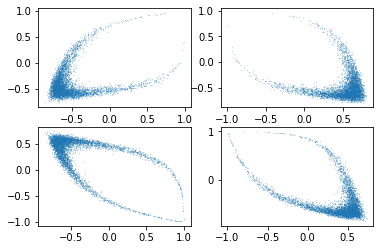

In [15]:
for i in range(4):
    a = tf.random.normal(shape = (1, ), mean = 3, stddev= 1)
    theta = tf.random.uniform(shape = (1, ), minval=0, maxval= 2*np.pi)

    f1 = tfb.Shift((0., -2.))
    f2 = tfb.Scale((1., 0.5))
    f3 = f3_class(a)
    f4 = f4_class(theta)
    f5 = tfp.bijectors.Tanh()
    transformation = tfb.Chain([f5, f4, f3, f2, f1])
    distribution = tfd.TransformedDistribution(tfd.MultivariateNormalDiag(loc = [[0, 0]] , scale_diag= [[0.3, 0.3]]), bijector = transformation)
    plt.subplot(2, 2, i + 1)
    plt.scatter(*distribution.sample(5000).numpy().T, s = 0.01)

In [73]:
# Helper function to compute transformed distribution densities

X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
inputs = np.transpose(np.stack((X, Y)), [1, 2, 0])

def get_densities(transformed_distribution):
    """
    This function takes a (batched) Distribution object as an argument, and returns a numpy 
    array Z of shape (batch_shape, 100, 100) of density values, that can be used to make a 
    contour plot with:
    plt.contourf(X, Y, Z[b, ...], cmap='hot', levels=100)
    where b is an index into the batch shape.
    """
    batch_shape = transformed_distribution.batch_shape
    Z = transformed_distribution.prob(np.expand_dims(inputs, 2)).numpy()
    Z = np.transpose(Z, list(range(2, 2+len(batch_shape))) + [0, 1])
    Z[np.isnan(Z)] = 0
    return Z.squeeze()

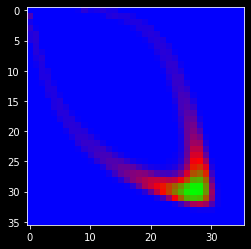

In [114]:
# Helper function to convert contour plots to numpy arrays

import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def get_image_array_from_density_values(Z, heatmap, size= 0.5):
    """
    This function takes a numpy array Z of density values of shape (100, 100)
    and returns an integer numpy array of shape (36, 36, 3) of pixel values for an image.
    """
    assert Z.shape == (100, 100)
    fig = Figure(figsize=(size, size))
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.contourf(X, Y, Z, cmap= heatmap, levels=100)
    ax.axis('off')
    fig.tight_layout(pad=0)

    ax.margins(0)
    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image_from_plot
plt.imshow(get_image_array_from_density_values(get_densities(distribution), heatmap= 'brg'))

In [76]:
def generate_distribution(a, theta):

    #Bijectors
    f1 = tfb.Shift((0., -2.))
    f2 = tfb.Scale((1., 0.5))
    f3 = f3_class(a)
    f4 = f4_class(theta)
    f5 = tfp.bijectors.Tanh()
    transformation = tfb.Chain([f5, f4, f3, f2, f1])
    # Distribution
    distribution = tfd.TransformedDistribution(
        tfd.MultivariateNormalDiag( loc = [[0, 0]],
                                    scale_diag= [[0.3, 0.3]]),
                                     bijector = transformation)
    return distribution

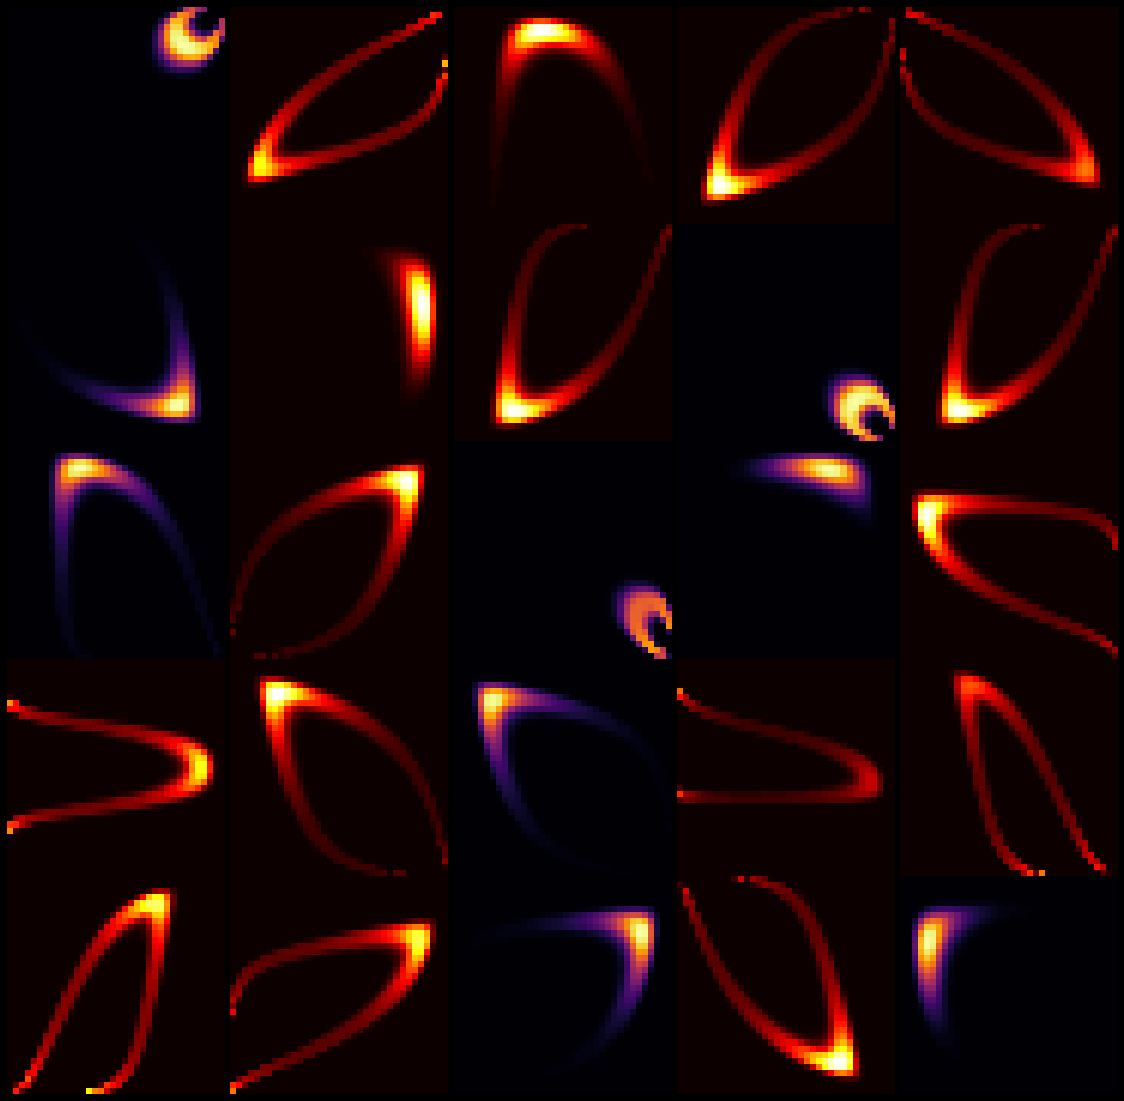

In [115]:
X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
inputs = np.transpose(np.stack((X, Y)), [1, 2, 0])
heatmap = ['inferno', 'hot', 'nipy_spectral']
plt.style.use('dark_background')
plt.figure(figsize=(20, 20))
for i in range(25):
    
    heatmap_index = np.random.randint(0, 2)
    a = tf.random.normal(shape = (1, ),
                        mean = np.random.normal(3, 0.7, size = 1),
                        stddev= np.random.lognormal(1, 0.5, size = 1))
    theta = tf.random.uniform(shape = (1, ), minval=0, maxval= 2*np.pi)
    my_distri = generate_distribution(a, theta)
    plt.subplot(5, 5, i + 1)
    plt.imshow(get_image_array_from_density_values(get_densities(my_distri),
                                                   heatmap = heatmap[heatmap_index]))
    plt.grid(b=None)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


In [121]:
from tqdm import tqdm
my_images = []
for i in tqdm(range(1000*10)):
    heatmap_index = np.random.randint(0, 2)
    a = tf.random.normal(shape = (1, ),
                        mean = np.random.normal(3, 0.7, size = 1),
                        stddev= np.random.lognormal(1, 0.5, size = 1))
    theta = tf.random.uniform(shape = (1, ), minval=0, maxval= 2*np.pi)
    my_distri = generate_distribution(a, theta)
    my_images.append(get_image_array_from_density_values(get_densities(my_distri),
                                                   heatmap = heatmap[heatmap_index]))

my_images = np.array(my_images)
print(my_images.shape)
np.save('weird_dataset.npy', my_images)

100%|██████████| 10000/10000 [22:19<00:00,  7.47it/s]


(10000, 36, 36, 3)


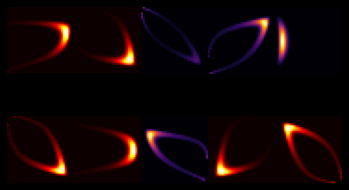

In [118]:
for i, image in enumerate(my_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.grid(b=None)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## TODO: Create tf.dataset, write the VAE architecture, train it, and interpolate.
# Plus translate the differential equations stuff to tf (diffusion probabilistic modelling) and try it out in this dataset.